In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchlayers as tl

In [8]:
import sys
import platform

print("ARCH:", platform.architecture())
print(torch.__version__)
print(torch.cuda.is_available())
torch.zeros(1).cuda()

ARCH: ('64bit', 'WindowsPE')
1.8.1
True


tensor([0.], device='cuda:0')

5141 4112 1029
Ssangyong


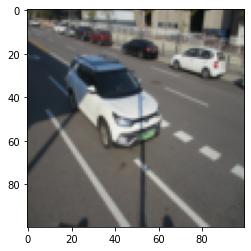

In [10]:
trans = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
datas = torchvision.datasets.ImageFolder(root = "./data/kcar", transform = trans)
labels = datas.classes

train_size = int(len(datas) * 0.8)
test_size = len(datas) - train_size
train_data, test_data = torch.utils.data.random_split(datas, [train_size, test_size])
img, label = test_data[0]
print(len(datas), len(train_data), len(test_data))
print(labels[label])
imshow(img)

In [9]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def imshow(img):
    img = img /2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    # plt.show()


In [11]:
class CNN(tl.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = tl.Conv2d(64, kernel_size=6)
        self.conv2 = tl.Conv2d(128, kernel_size=3)
        self.conv3 = tl.Conv2d(256, kernel_size=3, padding=1)
        self.fc1 = tl.Linear(120)
        self.fc2 = tl.Linear(60)
        self.fc3 = tl.Linear(10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, self.num_flat_features(x)) # [batch_size, 50, 4, 4]
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features


In [38]:
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = 16)

In [40]:
model = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    torch.nn.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.Conv(256, kernel_size=11),  # "same" padding as default
    tl.GlobalMaxPool(),  # Known from Keras
    tl.Linear(2),  # Output for 10 classes
)
model.cuda()

Sequential(
  (0): Conv(in_channels=?, out_channels=64, kernel_size=3, stride=1, padding=same, dilation=1, groups=1, bias=True, padding_mode=zeros)
  (1): ReLU()
  (2): BatchNorm(num_features=?, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv(in_channels=?, out_channels=128, kernel_size=3, stride=1, padding=same, dilation=1, groups=1, bias=True, padding_mode=zeros)
  (4): ReLU()
  (5): Conv(in_channels=?, out_channels=256, kernel_size=11, stride=1, padding=same, dilation=1, groups=1, bias=True, padding_mode=zeros)
  (6): GlobalMaxPool()
  (7): Linear(in_features=?, out_features=2, bias=True)
)

In [43]:
vgg_model = torchvision.models.vgg16(pretrained=True)
# arbitrary
last_module = nn.Linear(100, 2, bias=True)
vgg_model.add_module('last_module', last_module)
# last_module.apply(user_defined_initialize_function)
vgg_model.cuda()
model = vgg_model

In [44]:
# model = CNN()
# cnn = tl.build(model.cuda(), torch.randn(1, 3, 32, 32))
# criterion = torch.nn.CrossEntropyLoss()

# set optimizer. model.parameter를 넘겨준다.
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))
# optimizer = optim.SGD(model.parameters(), lr=0.01)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())

cuda:0 is available
True


In [32]:
model.train()  # 학습
for epoch in range(1):
  for index, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()  # 기울기 초기화
    output = model(data)
    # output = output.cuda()
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

    if index % 10 == 0:
      print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))

loss of 0 epoch, 0 index : 17.070871353149414
loss of 0 epoch, 10 index : 0.4695820212364197
loss of 0 epoch, 20 index : 0.5459007620811462
loss of 0 epoch, 30 index : 0.43971261382102966
loss of 0 epoch, 40 index : 0.5181875228881836
loss of 0 epoch, 50 index : 0.3025418817996979
loss of 0 epoch, 60 index : 0.14970053732395172
loss of 0 epoch, 70 index : 0.39472028613090515
loss of 0 epoch, 80 index : 0.4411460757255554
loss of 0 epoch, 90 index : 0.3453773856163025
loss of 0 epoch, 100 index : 0.04572344571352005
loss of 0 epoch, 110 index : 0.26603469252586365
loss of 0 epoch, 120 index : 0.15716403722763062
loss of 0 epoch, 130 index : 0.18139122426509857
loss of 0 epoch, 140 index : 0.20153164863586426
loss of 0 epoch, 150 index : 0.04743877798318863
loss of 0 epoch, 160 index : 0.43580570816993713
loss of 0 epoch, 170 index : 0.005175290163606405
loss of 0 epoch, 180 index : 0.010715260170400143
loss of 0 epoch, 190 index : 0.544895589351654
loss of 0 epoch, 200 index : 0.0938669

In [36]:
model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    test_loss += criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

RuntimeError: CUDA out of memory. Tried to allocate 2.46 GiB (GPU 0; 6.00 GiB total capacity; 3.37 GiB already allocated; 964.70 MiB free; 3.45 GiB reserved in total by PyTorch)